In [1]:
from utils import *
import tensorflow as tf
from sklearn.cross_validation import train_test_split
import time
import random

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
trainset = sklearn.datasets.load_files(container_path = 'data', encoding = 'UTF-8')
trainset.data, trainset.target = separate_dataset(trainset,1.0)
print (trainset.target_names)
print (len(trainset.data))
print (len(trainset.target))

['negative', 'positive']
10662
10662


In [3]:
train_X, test_X, train_Y, test_Y = train_test_split(trainset.data, trainset.target,
                                                    test_size = 0.2)

In [4]:
concat = ' '.join(trainset.data).split()
vocabulary_size = len(list(set(concat)))
data, count, dictionary, rev_dictionary = build_dataset(concat, vocabulary_size)
print('vocab from size: %d'%(vocabulary_size))
print('Most common words', count[4:10])
print('Sample data', data[:10], [rev_dictionary[i] for i in data[:10]])

vocab from size: 20332
Most common words [('film', 1453), ('movie', 1270), ('one', 727), ('like', 721), ('story', 477), ('much', 386)]
Sample data [540, 2553, 3224, 18482, 36, 9566, 219, 150, 19, 4018] ['rock', 'destined', '21st', 'centurys', 'new', 'conan', 'hes', 'going', 'make', 'splash']


In [5]:
GO = dictionary['GO']
PAD = dictionary['PAD']
EOS = dictionary['EOS']
UNK = dictionary['UNK']

In [6]:
def _pairwise_distances(embeddings, squared=False):
    dot_product = tf.matmul(embeddings, tf.transpose(embeddings))
    square_norm = tf.diag_part(dot_product)
    distances = tf.expand_dims(square_norm, 1) - 2.0 * dot_product + tf.expand_dims(square_norm, 0)
    distances = tf.maximum(distances, 0.0)

    if not squared:
        mask = tf.to_float(tf.equal(distances, 0.0))
        distances = distances + mask * 1e-16
        distances = tf.sqrt(distances)
        distances = distances * (1.0 - mask)

    return distances


def _get_anchor_positive_triplet_mask(labels):
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    mask = tf.logical_and(indices_not_equal, labels_equal)

    return mask


def _get_anchor_negative_triplet_mask(labels):
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    mask = tf.logical_not(labels_equal)

    return mask


def _get_triplet_mask(labels):
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)
    i_not_equal_j = tf.expand_dims(indices_not_equal, 2)
    i_not_equal_k = tf.expand_dims(indices_not_equal, 1)
    j_not_equal_k = tf.expand_dims(indices_not_equal, 0)

    distinct_indices = tf.logical_and(tf.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)

    label_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    i_equal_j = tf.expand_dims(label_equal, 2)
    i_equal_k = tf.expand_dims(label_equal, 1)

    valid_labels = tf.logical_and(i_equal_j, tf.logical_not(i_equal_k))
    mask = tf.logical_and(distinct_indices, valid_labels)

    return mask


def batch_all_triplet_loss(labels, embeddings, margin, squared=False):
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # shape (batch_size, batch_size, 1)
    anchor_positive_dist = tf.expand_dims(pairwise_dist, 2)
    assert anchor_positive_dist.shape[2] == 1, "{}".format(anchor_positive_dist.shape)
    # shape (batch_size, 1, batch_size)
    anchor_negative_dist = tf.expand_dims(pairwise_dist, 1)
    assert anchor_negative_dist.shape[1] == 1, "{}".format(anchor_negative_dist.shape)

    triplet_loss = anchor_positive_dist - anchor_negative_dist + margin

    mask = _get_triplet_mask(labels)
    mask = tf.to_float(mask)
    triplet_loss = tf.multiply(mask, triplet_loss)

    # Remove negative losses (i.e. the easy triplets)
    triplet_loss = tf.maximum(triplet_loss, 0.0)

    # Count number of positive triplets (where triplet_loss > 0)
    valid_triplets = tf.to_float(tf.greater(triplet_loss, 1e-16))
    num_positive_triplets = tf.reduce_sum(valid_triplets)
    num_valid_triplets = tf.reduce_sum(mask)
    fraction_positive_triplets = num_positive_triplets / (num_valid_triplets + 1e-16)

    # Get final mean triplet loss over the positive valid triplets
    triplet_loss = tf.reduce_sum(triplet_loss) / (num_positive_triplets + 1e-16)

    return triplet_loss, fraction_positive_triplets

In [7]:
class Model:
    def __init__(self, size_layer, num_layers, embedded_size,
                 dict_size, dimension_output):
        
        def cells(reuse=False):
            return tf.nn.rnn_cell.LSTMCell(size_layer,initializer=tf.orthogonal_initializer(),reuse=reuse)
        
        def rnn(embedded,reuse=False):
            with tf.variable_scope('model', reuse=reuse):
                rnn_cells = tf.nn.rnn_cell.MultiRNNCell([cells() for _ in range(num_layers)])
                outputs, _ = tf.nn.dynamic_rnn(rnn_cells, embedded, dtype = tf.float32)
                W = tf.get_variable('w',shape=(size_layer, dimension_output),initializer=tf.orthogonal_initializer())
                b = tf.get_variable('b',shape=(dimension_output),initializer=tf.zeros_initializer())
                return tf.matmul(outputs[:, -1], W) + b
              
        self.X = tf.placeholder(tf.int32, [None, None])
        self.Y = tf.placeholder(tf.int32, [None])
        embeddings = tf.Variable(tf.random_uniform([dict_size, embedded_size], -1, 1))
        embedded = tf.nn.embedding_lookup(embeddings, self.X)
        self.logits = rnn(embedded,False)
        self.cost, fraction = batch_all_triplet_loss(self.Y, self.logits, margin=0.5, squared=False)
        self.optimizer = tf.train.AdamOptimizer(1e-3).minimize(self.cost)

In [8]:
size_layer = 128
num_layers = 2
embedded_size = 128
dimension_output = 2
maxlen = 50
batch_size = 64

In [9]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(size_layer,num_layers,embedded_size,len(dictionary),dimension_output)
sess.run(tf.global_variables_initializer())

In [10]:
train_X = str_idx(train_X,dictionary,maxlen)
test_X = str_idx(test_X,dictionary,maxlen)

In [11]:
for i in range(10):
    total_loss = 0
    for index in range(0,len(train_X),batch_size):
        batch_x = train_X[index:min(index+batch_size,len(train_X))]
        batch_y = train_Y[index:min(index+batch_size,len(train_X))]
        loss, _ = sess.run([model.cost,model.optimizer],feed_dict={model.X:batch_x,model.Y:batch_y})
        total_loss += loss
    total_loss /= len(train_X)
    print('epoch: %d, avg cost: %f'%(i+1,total_loss))

epoch: 1, avg cost: 0.007871
epoch: 2, avg cost: 0.007863
epoch: 3, avg cost: 0.007891
epoch: 4, avg cost: 0.007887
epoch: 5, avg cost: 0.008034
epoch: 6, avg cost: 0.007933
epoch: 7, avg cost: 0.008077
epoch: 8, avg cost: 0.008238
epoch: 9, avg cost: 0.007795
epoch: 10, avg cost: 0.007743


In [12]:
logits_train = sess.run(model.logits,feed_dict={model.X:train_X})
logits_test = sess.run(model.logits,feed_dict={model.X:test_X})
logits_test.shape

(2133, 2)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import offsetbox

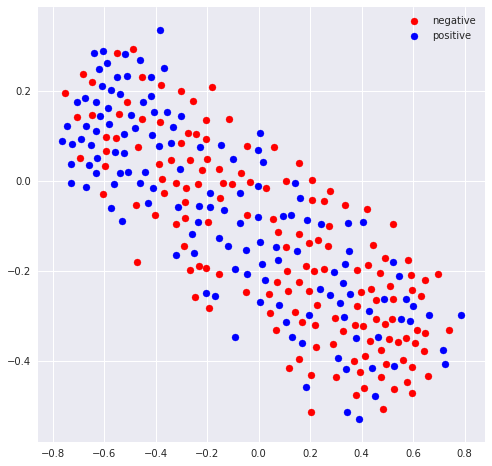

In [14]:
ax_min = np.min(logits_test,0)
ax_max = np.max(logits_test,0)
ax_dist_sq = np.sum((ax_max-ax_min)**2)
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
shown_images = np.array([[1., 1.]])
colors = ['b','r']
for i in range(logits_test.shape[0]):
    dist = np.sum((logits_test[i] - shown_images)**2, 1)
    if np.min(dist) < 3e-4*ax_dist_sq:
        continue
    shown_images = np.r_[shown_images, [logits_test[i]]]
    plt.scatter(logits_test[i,0],logits_test[i,1],c=colors[test_Y[i]])
plt.legend(['negative','positive'])
plt.show()

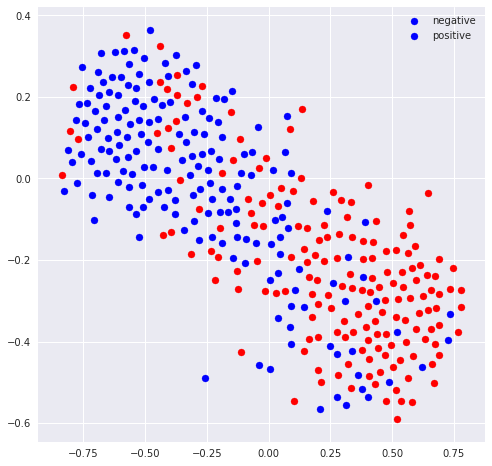

In [15]:
ax_min = np.min(logits_train,0)
ax_max = np.max(logits_train,0)
ax_dist_sq = np.sum((ax_max-ax_min)**2)
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
shown_images = np.array([[1., 1.]])
colors = ['b','r']
for i in range(logits_train.shape[0]):
    dist = np.sum((logits_train[i] - shown_images)**2, 1)
    if np.min(dist) < 3e-4*ax_dist_sq:
        continue
    shown_images = np.r_[shown_images, [logits_train[i]]]
    plt.scatter(logits_train[i,0],logits_train[i,1],c=colors[train_Y[i]])
plt.legend(['negative','positive'])
plt.show()